In [1]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
mem=Memory("./mycache")

@mem.cache
def get_training_data():
    data=load_svmlight_file("D:\Ipython_data\A9a.txt")
    return data[0],data[1]
x_train,y_train=get_training_data()
def get_testing_data():
    data=load_svmlight_file("D:\Ipython_data\A9at.txt")
    return data[0],data[1]
x_test,y_test=get_testing_data()

In [2]:
class LinearClassification(object):
    def __init__(self,Learning_rate=0.003,epoch=8):
        self.Learning_rate=Learning_rate
        self.epoch=epoch

    def fit_nag(self,x,Y,threshold,C):
        self.w=np.zeros((1,1+x.shape[1]))
        self.v=np.zeros((1,x.shape[1]))
        self.cost_list=[]
        self.threshold=threshold
        self.C=C
        self.y=0.09
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[0]):
                output=self.Classification_input(x[j,:],self.threshold)
                if(output!=Y[j]):
                    #计算动量项
                    t=Y[j]*(x[j,:])
                    #print('t.shape:',t.shape)
                    #print('self.w.shape:',self.w.shape)
                    #print('self.v.shape:',self.v.shape)
                    #print('self.y.shape:',self.y.shape)
                    dwv=-self.C*t+self.w[0,1:]-self.y*self.v
                    self.v=self.y*self.v+self.Learning_rate*dwv
                    
                    #计算cost值
                    cost+=(1-Y[j]*output)
                    #print('cost:',cost)
                    #更新w
                    self.w[0,1:]=self.w[0,1:]-self.v
                    self.w[0,0]=self.w[0,0]-self.v.sum()
            self.w1=self.w.T
            cost=cost+(self.w*self.w1).sum()/2
            self.cost_list.append(cost)
        return self
                    
    def fit_adadelta(self,x,Y,threshold,C):
        self.e=10**(-8)
        self.cost_list=[]
        self.w=np.zeros((1,1+x.shape[1]))
        self.v=np.zeros((1,1+x.shape[1]))
        self.threshold=threshold
        self.C=C
        self.y=0.9
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[0]):
                output=self.Classification_input(x[j,:],self.threshold)
                if(output!=Y[j]):
                    #计算梯度gt
                    t=Y[j]*(x[j,:])
                    g=self.w[0,1:]-self.C*t
                    
                    #计算E[g^2]t
                    g1=g.T
                    E=(g*g1).sum()
                    
                    #计算RMS[g]t
                    RMSgt=np.sqrt(self.e+E)
                    
                    #计算dθt,保留学习率
                    dw=(-self.Learning_rate/RMSgt)*g
                    
                    #计算E[dw^2]t-1
                    dw1=dw.T
                    Edwt=(dw*dw1).sum()
                    
                    #计算RMS[dw]t-1
                    RMSwt1=np.sqrt(Edwt+self.e)
                    
                    #计算dθt,去除学习率
                    dwt=-(RMSwt1/RMSgt)*g
                    
                    #计算E[dw^2]t,dw1是dw转置
                    dw1=dw.T
                    Edwt=self.y*Edwt+(1-self.y)*((dw*dw1).sum())
                    
                    #计算cost
                    cost+=(1-Y[j]*output)
                    
                    #更新w
                    self.w[0,1:]=self.w[0,1:]+dwt
                    self.w[0,0]=self.w[0,0]+dwt.sum()
            self.w1=self.w.T
            cost=cost+(self.w*self.w1).sum()/2
            self.cost_list.append(cost)
        return self
    
    def fit_rms(self,x,Y,threshold,C):
        self.e=10**(-8)
        self.cost_list=[]
        self.w=np.zeros((1,1+x.shape[1]))
        self.v=np.zeros((1,1+x.shape[1]))
        self.threshold=threshold
        self.C=C
        self.y=0.9
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[0]):
                output=self.Classification_input(x[j,:],self.threshold)
                if(output!=Y[j]):
                    #计算梯度gt
                    t=Y[j]*(x[j,:])
                    g=self.w[0,1:]-self.C*t
                    
                    #计算E[g^2]t
                    g1=g.T
                    E=(g*g1).sum()
                    
                    #计算RMS[g]t
                    RMSgt=np.sqrt(self.e+E)
                    
                    #计算dw
                    dw=(-self.Learning_rate/RMSgt)*g
                    
                    #计算cost
                    cost+=(1-Y[j]*output)
                    
                    #更新w
                    self.w[0,1:]=self.w[0,1:]+dw
                    self.w[0,0]=self.w[0,0]+dw.sum()
            self.w1=self.w.T
            cost=cost+(self.w*self.w1).sum()/2
            self.cost_list.append(cost)
        return self 
    
    def fit_Adam(self,x,Y,threshold,C):
        self.e=10**(-8)
        self.cost_list=[]
        self.w=np.zeros((1,1+x.shape[1]))
        self.m=np.zeros((1,x.shape[1]))
        self.v=0
        self.C=C
        self.threshold=threshold
        self.p1=0.9
        self.p2=0.999
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[1]):
                output=self.Classification_input(x[j,:],self.threshold)
                if(output!=Y[i]):
                    #计算梯度gt
                    t=Y[j]*(x[j,:])
                    g=self.w[0,1:]-self.C*t
                    
                    #计算m
                    self.m=self.m*self.p1+(1-self.p1)*g
                    
                    #计算m的修正误差M
                    M=self.m/(1-(self.p1**(j+1)))
                    
                    #计算v
                    g1=g.T
                    G=(g1*g).sum()
                    self.v=self.v*self.p2+(1-self.p2)*G
                    
                    #计算V
                    V=self.v/(1-(self.p2**(j+1)))
                    
                    #计算cost
                    cost+=(1-Y[j]*output)
                    
                    #计算W
                    self.w[0,1:]=self.w[0,1:]-(self.Learning_rate/(np.sqrt(V)+self.e))*M
                    self.w[0,0]=self.w[0,0]-((self.Learning_rate/(np.sqrt(V)+self.e))*M).sum()
            self.w1=self.w.T
            cost=cost+(self.w*self.w1).sum()/2
            print(cost)
            self.cost_list.append(cost)
        return self 
                    
    
    def Classification_input(self,x,threshold):
        #print('x.shape:',x.shape)
        #print('w[0,1:].shape:',self.w[0,1:].shape)
        f=x*self.w[0,1:]+self.w[0,0]
        if(f>=threshold):
            return 1
        else:
            return -1

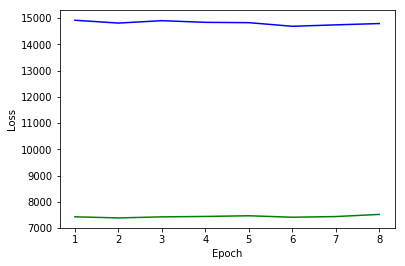

In [5]:
import numpy as np
import matplotlib.pyplot as plt
model3=LinearClassification()
model3.fit_nag(x_train,y_train,0,0.01)
model4=LinearClassification()
model4.fit_nag(x_test,y_test,0,0.01)

plt.plot(range(1,model3.epoch+1),model3.cost_list,'b-',range(1,model4.epoch+1),model4.cost_list,'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

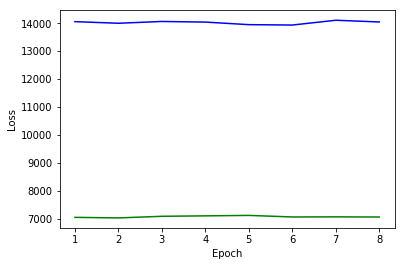

In [6]:
model5=LinearClassification()
model5.fit_adadelta(x_train,y_train,0,1)
model6=LinearClassification()
model6.fit_adadelta(x_test,y_test,0,1)

plt.plot(range(1,model5.epoch+1),model5.cost_list,'b-',range(1,model6.epoch+1),model6.cost_list,'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

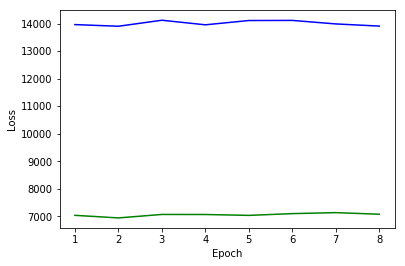

In [7]:
model7=LinearClassification()
model7.fit_rms(x_train,y_train,0,1)
model8=LinearClassification()
model8.fit_rms(x_test,y_test,0,1)

plt.plot(range(1,model7.epoch+1),model7.cost_list,'b-',range(1,model8.epoch+1),model8.cost_list,'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

2.000018
1.79999974286e-05
1.79999974286e-05
1.79999974286e-05
1.79999974286e-05
1.79999974286e-05
1.79999974286e-05
62.0079309721
2.000018
1.79999974286e-05
52.0166004217
52.0162744666
0.0162744665706
0.0162744665706
0.0162744665706
52.0159020944


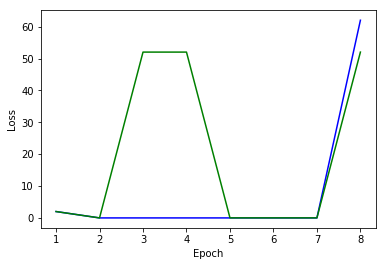

In [8]:
model9=LinearClassification()
model9.fit_Adam(x_train,y_train,0,0.01)
model10=LinearClassification()
model10.fit_Adam(x_test,y_test,0,0.01)

plt.plot(range(1,model9.epoch+1),model9.cost_list,'b-',range(1,model10.epoch+1),model10.cost_list,'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()